# 2. Uma previsão de vendas para o próximo período mensal

In [1309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Análise

In [1412]:
# Lendo o dataset
df = pd.read_csv("superstore_dataset2011-2015.csv",encoding = "ISO-8859-1")

In [1413]:
# Transformando a coluna Order Date no formato data
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [1416]:
#Variáveis criadas na análise de impacto das vendas
df["Per_ship"] = (df["Shipping Cost"] / df["Sales"])

df["bool_Discount"] = [0 if (i == 0) else 1 for i in df.Discount]

def categorias_ship(val):
    if (val > 0) & (val <= 0.10):
        return "0.0 - 0.10"
    elif (val > 0.10) & (val <= 0.20):
        return "0.11 - 0.20"
    elif (val > 0.20) & (val <= 0.30):
        return "0.21 - 0.30"
    elif (val > 0.30):
        return "0.31 - 0.60"

df['cat_ship'] = df['Per_ship'].apply(categorias_ship)


A ideia principal foi utilizar apenas as variaveis categoricas no modelo.

In [1417]:
# Agrupando pelas variáveis que mais pesam sobre as vendas
# As variáveis bool_Discount e cat_ship foram criadas na analise de impacto das vendas.
dados = df.groupby(['Order Date','Segment','Country','Category','bool_Discount',"cat_ship"])['Sales'].sum().reset_index()

# Criando novas váriaveis temporais para auxiliar o modelo
dados["Year"]     = dados['Order Date'].dt.year
dados["Month"]    = dados['Order Date'].dt.month
dados["DayMonth"] = dados['Order Date'].dt.day
dados["DayWeek"]  = dados['Order Date'].dt.dayofweek
dados["DayYear"]  = dados['Order Date'].dt.dayofyear
dados["weekYear"] = dados['Order Date'].dt.week
dados["Quarter"]  = dados['Order Date'].dt.quarter


In [1418]:
# Transformando as variáveis categoricas em dummys
df_dummies = pd.get_dummies(dados,drop_first=True)

# Separando meu conjunto de teste pelas vendas ocorridas entre 2011 a 2013. E treino para as vendas de 2014
treino = df_dummies[df_dummies["Year"] < 2014]
teste  = df_dummies[(df_dummies["Year"] == 2014)]

X_train, X_test, y_train, y_test = treino.drop(['Sales','Order Date'], axis=1), teste.drop(['Sales','Order Date'], axis=1), treino[['Sales']], teste[['Sales']]


In [1419]:
# Utilizando o StandardScaler para padronizar meu dataset
sc = StandardScaler()

sc.fit(X_train)

x_train = sc.transform(X_train)
x_test  = sc.transform(X_test)

In [1375]:
# Modelo base
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)

rfr.fit(x_train, y_train)

rfr_y_pred = rfr.predict(x_test)

<ipython-input-1375-f26d2dfd20a7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(x_train, y_train)


#### Usaremos o MAE - Erro médio absoluto como métrica para a nossa análise.

In [1376]:
print("Mae: ", mean_absolute_error(y_test, rfr_y_pred))

Mae:  310.7671878582066


In [1360]:
# 2° Modelo
# Fazendo um grid search para encontar os parâmetros do modelo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


param_tuning = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [ 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators' : [100, 200, 500],
    'objective': ['reg:squarederror']
}

xgb_model = XGBRegressor()

gsearch   = GridSearchCV(  estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

gsearch.fit(x_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 169.4min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 174.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1], 'max_depth': [5, 7, 10],
                         'min_chil

In [1361]:
# Os melhores parâmetros encontrados
gsearch.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [1377]:
# Treinando o modelo com os parametros encontrados
xgb_model = XGBRegressor(colsample_bytree=0.7,
                         learning_rate=0.01,
                         max_depth= 5,
                         min_child_weight= 1,
                         n_estimators= 500,
                         objective= 'reg:squarederror',
                         subsample= 0.7)


xgb_model.fit(x_train,y_train)

y_pred = xgb_model.predict(x_test)


In [1422]:
print("Mae: ", mean_absolute_error(y_test, y_pred))

Mae:  276.0018207898269


In [1420]:
#Criando um dataset para visualizar o resultado
df_view = dados[(dados["Year"] == 2014)]
df_view["Model"] = y_pred


real = df_view.groupby('Order Date')['Sales'].sum().reset_index()
real = real.set_index(['Order Date'])

modelo = df_view.groupby('Order Date')['Model'].sum().reset_index()
modelo = modelo.set_index('Order Date')


df_treino = pd.concat([real, modelo], axis=1)
df_treino["Erro"] = df_treino["Sales"] - df_treino["Model"]

<ipython-input-1420-e06adce1acaa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_view["Model"] = y_pred


#### Visualmente Valores reais vs Previstos


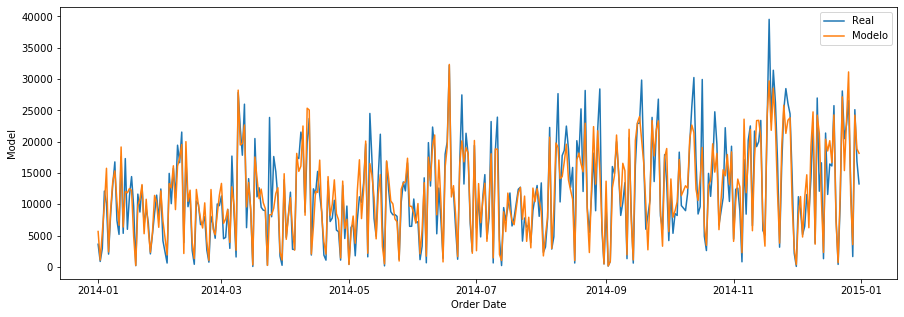

In [1421]:
plt.figure(figsize=(15,5))

sns.lineplot( x=real.index, y="Sales", data = real, label = 'Real')
sns.lineplot( x=modelo.index, y="Model", data = modelo, label = 'Modelo')

### Gráfico QQ plot do resíduo (dispersão):
Gráfico que mostra onde o resíduo deveria estar distribuído teoricamente, seguindo uma distribuição gaussiana, contra como ele realmente ficou.

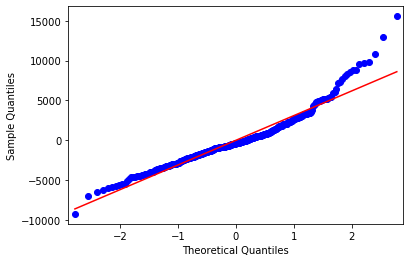

In [1423]:
sm.graphics.qqplot(df_treino.iloc[:,2], line='r');
    

### As features mais importantes encontradas pelo modelo.

<BarContainer object of 30 artists>

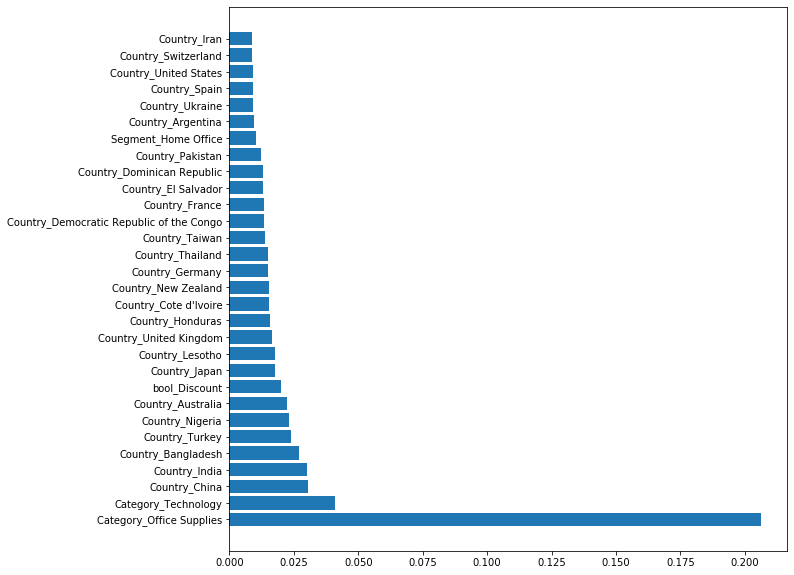

In [1424]:
results = pd.DataFrame()
results['columns']= X_train.columns
results['importances'] = xgb_model.feature_importances_

plt.figure(figsize=(10,10))

results.sort_values( by='importances', ascending=False, inplace=True)
results.head()
plt.barh(results.iloc[:30,0],results.iloc[:30,1])